# QGS model: Example of DiffEqPy usage

## Preamble

This notebook shows how to use the [DiffEqPy](https://github.com/SciML/diffeqpy) package to integrate the qgs model and compare with the qgs Runge-Kutta integrator.

**You must finish the install of DiffEqPy manually before running this notebook!**

The DiffEqPy package first installation step is done by Anaconda in the qgs environment but then you must install [Julia](https://julialang.org/downloads/) and follow the final manual installation instruction found in the link above.

These can be summed up as opening a terminal and doing:
```
conda activate qgs
python
```
and then inside the Python command line interface do:

```
>>> import diffeqpy
>>> diffeqpy.install()
```
which will then finalize the installation.

## Reinhold and Pierrehumbert 1982 model version

This notebook use the model version with a simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley). 

More detail can be found in the articles:
* Reinhold, B. B., & Pierrehumbert, R. T. (1982). *Dynamics of weather regimes: Quasi-stationary waves and blocking*. Monthly Weather Review, **110** (9), 1105-1145. [doi:10.1175/1520-0493(1982)110%3C1105:DOWRQS%3E2.0.CO;2](https://doi.org/10.1175/1520-0493(1982)110%3C1105:DOWRQS%3E2.0.CO;2)
* Cehelsky, P., & Tung, K. K. (1987). *Theories of multiple equilibria and weather regimes—A critical reexamination. Part II: Baroclinic two-layer models*. Journal of the atmospheric sciences, **44** (21), 3282-3303. [doi:10.1175/1520-0469(1987)044%3C3282%3ATOMEAW%3E2.0.CO%3B2](https://doi.org/10.1175/1520-0469(1987)044%3C3282%3ATOMEAW%3E2.0.CO%3B2)

or in the documentation and on [readthedocs](https://qgs.readthedocs.io/en/latest/files/model/oro_model.html).

## Modules import

First, setting the path and loading of some modules

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../')])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [4]:
np.random.seed(210217)

Importing the model's modules

In [5]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

Importing Julia DifferentialEquations.jl package

In [6]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

FileNotFoundError: [Errno 2] No such file or directory: 'julia'

Importing also Numba

In [7]:
from numba import jit

Ignoring Numba performance warnings. -- Comment to disable if you want to see them.

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Systems definition

General parameters

In [9]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 5

number_of_trajectories = 1
number_of_perturbed_trajectories = 10

Setting some model parameters

In [10]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.3})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model_parameters.ground_params.set_orography(0.4, 1)
model_parameters.atemperature_params.set_thetas(0.2, 0)

In [11]:
# Printing the model's parameters
model_parameters.print_params()

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.3    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.2777777777777778    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'hd': 0.3  [nondim]  (Newtonian cooling coefficient),
'thetas[1]': 0.2    (spectral components 1 of the temperature profile),
'thetas[2]': 0.0    (spe

Creating the tendencies function

In [12]:
%%time
f, Df = create_tendencies(model_parameters)

CPU times: user 11 s, sys: 1.54 s, total: 12.6 s
Wall time: 11.9 s


## Time integration

Defining an integrator

In [13]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors

In [14]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

CPU times: user 25.2 ms, sys: 52.4 ms, total: 77.6 ms
Wall time: 18.4 s


Now integrate to obtain with the qgs RK4 integrator

In [15]:
%%time
integrator.integrate(0., 200., dt, ic=ic, write_steps=write_steps)
time, traj = integrator.get_trajectories()

CPU times: user 2 ms, sys: 4 ms, total: 6 ms
Wall time: 3.56 s


And also with the DifferentialEquations ODE Solver

In [ ]:
# defining a function with the correct header

@jit
def f_jl(x,p,t):
    u = f(t,x)
    return u

In [ ]:
%%time
# Defining the problem and integrating
prob = de.ODEProblem(f_jl, ic, (0., 200.))
sol = de.solve(prob, saveat=write_steps * dt)

Plotting the result

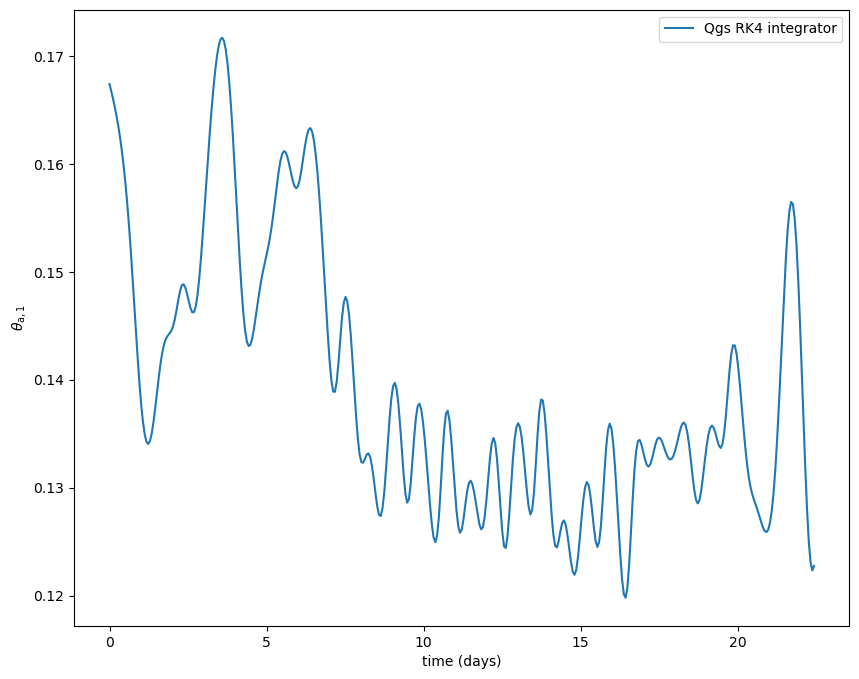

In [16]:
var = 10
#jtraj = np.array(sol.u).T
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var], label="Qgs RK4 integrator")
#plt.plot(model_parameters.dimensional_time*time, jtraj[var], label="DiffEqPy default integrator")

plt.legend()
plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');